In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


In [2]:
# CSV 파일을 읽어와 DataFrame으로 저장
df = pd.read_csv('total_data.csv')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821790 entries, 0 to 1821789
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   be_date          object 
 1   be_ac_energy     float64
 2   be_light_energy  float64
 3   be_plug_energy   float64
 4   be_total_energy  float64
 5   be_floor         int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 83.4+ MB
None


In [52]:
import matplotlib.pyplot as plt

# 'be_date'를 기준으로 에너지 관련 열을 가져와 'ds', 'y'로 이름 변경
df = df[['be_date', 'be_light_energy']].rename(columns={'be_date': 'ds', 'be_light_energy': 'y'})

# 데이터 전처리: 'ds' 열을 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])

# 최근 2주 데이터 선택
recent_data = df[df['ds'] >= (df['ds'].max() - pd.Timedelta(days=30))]

# 5분 간격으로 데이터 집계
recent_data = recent_data.groupby(pd.Grouper(key='ds', freq='1T')).agg({
    'y': 'sum'
}).reset_index()
# 이상치 제거
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]

# # 그래프 그리기
# fig, ax = plt.subplots(figsize=(15, 8))

# recent_data.plot(x='ds', y='y', ax=ax, linewidth=2)
# ax.set_title


In [3]:
# 'be_date'를 기준으로 에너지 관련 열을 가져와 'ds', 'y'로 이름 변경
df = df[['be_date', 'be_light_energy']].rename(columns={'be_date': 'ds', 'be_light_energy': 'y'})

# 데이터 전처리: 'ds' 열을 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])

# 5분 간격으로 데이터 집계
df = df.groupby(pd.Grouper(key='ds', freq='1T')).agg({
    'y': 'sum'
}).reset_index()
# 이상치 제거
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]

# 7월 데이터만 선택하여 모델 학습
train_df = df[(df['ds'] >= '2018-07-02') & (df['ds'] < '2018-11-09')]

# 'is_weekend' 열 추가
train_df['is_weekend'] = (train_df['ds'].dt.dayofweek >= 5).astype(int)

C:\Users\rlarb\anaconda3\envs\kim\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
# Prophet 모델 초기화 및 파라미터 튜닝
model = Prophet(
    yearly_seasonality=False,
    daily_seasonality=True,
    changepoint_prior_scale=0.02,  # 변화점의 유연성을 높임
    holidays_prior_scale=10.0,     # 휴일 효과의 유연성을 높임|
    seasonality_prior_scale=15.0  # seasonality_prior_scale 값을 높게 조정
)
# 주말에 대한 주간 트렌드 추가
model.add_seasonality(name='weekend', period=7, fourier_order=40, condition_name='is_weekend')


In [5]:
# 모델 훈련
model.fit(train_df)


10:45:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# 미래 날짜 생성 (일주일 동안의 5분 간격 데이터 생성)
future = pd.date_range(start=train_df['ds'].max(), periods=7*24*60, freq='1T')
future_df = pd.DataFrame({'ds': future, 'is_weekend': (future.dayofweek >= 5).astype(int)})


In [7]:
# 예측
forecast = model.predict(future_df)

C:\Users\rlarb\anaconda3\envs\kim\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlarb\anaconda3\envs\kim\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlarb\anaconda3\envs\kim\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlarb\anaconda3\envs\kim\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rlarb\anaconda3\envs\kim\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(b

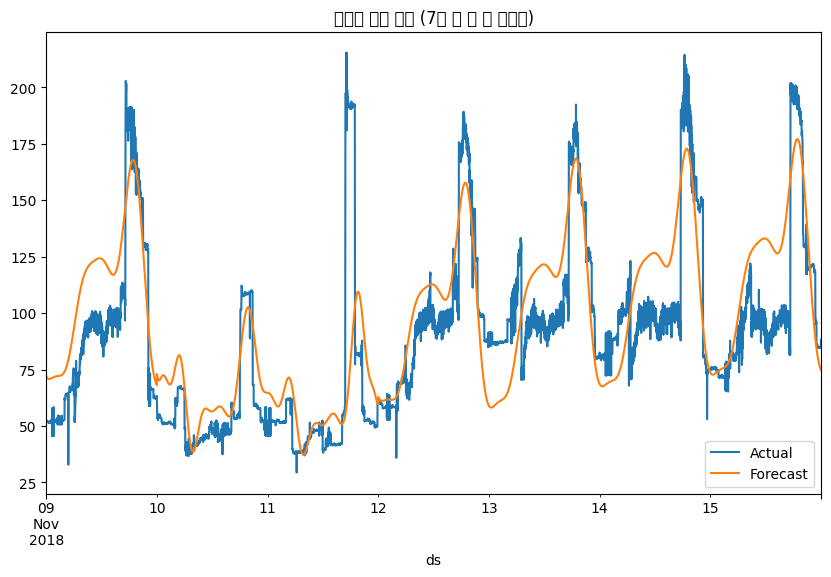

In [8]:
# 결과 시각화
fig, ax = plt.subplots(figsize=(10, 6))
# 실제값 (7월 한 달 데이터)
actual_data = df[(df['ds'] >= '2018-11-09') & (df['ds'] < '2018-11-16')]
actual_data.plot(x='ds', y='y', label='Actual', ax=ax)
# 예측값 (일주일 예측 데이터)
forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)

ax.set_title('에너지 소비 예측 (7월 한 달 및 일주일)')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 평가 지표 계산
actual_values = actual_data['y'].values
predicted_values = forecast['yhat'].values

mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 586.0280591146982
Mean Absolute Error (MAE): 18.604596753145376
R-squared (R2): 0.6184798077566345
